In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F

In [4]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.utils.data

In [5]:
#transform
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        lambda x: x>0.5,
        lambda x: x.float(),
    ])

In [6]:
# dataset loading
bsize = 100
train_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=True, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dset.MNIST('data', train=False, download=True, transform=data_transforms), batch_size=bsize, shuffle=True)

In [7]:
# hyperparameters
N = 5
k = 2
tau = 1.

In [8]:
# gumbel-softmax
def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape)
    return -Variable(torch.log(-torch.log(U + eps) + eps))

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature):
    """
    input: [*, n_class]
    return: [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    return (y_hard - y).detach() + y

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = self.relu(self.fc2(h1))
        return l

In [10]:
class Tunnel(nn.Module):
    def __init__(self):
        super(Tunnel, self).__init__()
        self.fc1 = nn.Linear(128, 128)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        l = self.relu(self.fc1(x))
        return l

In [11]:
class Output(nn.Module):
    def __init__(self):
        super(Output, self).__init__()
        self.fc1 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        l = h1.view(-1,2)
        return l

In [12]:
def prob(outputs):
    outputs = [F.softmax(out, dim=-1) for out in outputs]
    return torch.cat(outputs, dim=1).view(-1, N, k)

def sample(l):
    return gumbel_softmax(l, tau)

def signal(outputs):
    outputs = [sample(out).narrow(1,0,1) for out in outputs]
    return torch.cat(outputs, dim=1)

In [13]:
class Decoder(nn.Module):  
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(N, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)      
        self.fc4 = nn.Linear(512, 784)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        h3 = self.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        o = h4.view(-1,784)
        return F.sigmoid(o)

In [14]:
E = Encoder()
D = Decoder()
O0 = Output()
Os = [Output() for _ in range(N-1)]
Ts = [Tunnel() for _ in range(N-1)]

In [15]:
# objective
def loss_function(recon_x, x, q):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
    KLD = torch.sum(q*(torch.log(q+1E-20)-np.log(1/k)))

    return BCE + KLD

In [16]:
# training
epochs = 15

params = [
    {'params':E.parameters()},
    {'params':D.parameters()},
    {'params':O0.parameters()},
] + [{'params':o.parameters()} for o in Os] \
  + [{'params':t.parameters()} for t in Ts]
optimizer = optim.Adam(params, lr=1e-4)

train_loss = 0
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        x = data.view(-1,784)
        optimizer.zero_grad()
        sofar = E(x)
        outputs = [O0(sofar)]
        for n in range(len(Ts)):
            sofar = Ts[n](sofar)
            outputs.append(Os[n](sofar))
        bits = signal(outputs)
        q = prob(outputs)
        recon_x = D(bits)
        loss = loss_function(recon_x, x, q)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch+1, train_loss / len(train_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 542.819766
Train Epoch: 1 [20000/60000 (33%)]	Loss: 206.488242
Train Epoch: 1 [40000/60000 (67%)]	Loss: 199.928691
====> Epoch: 1 Average loss: 237.9847
Train Epoch: 2 [0/60000 (0%)]	Loss: 205.689180
Train Epoch: 2 [20000/60000 (33%)]	Loss: 190.525449
Train Epoch: 2 [40000/60000 (67%)]	Loss: 192.103770
====> Epoch: 2 Average loss: 436.5382
Train Epoch: 3 [0/60000 (0%)]	Loss: 191.615879
Train Epoch: 3 [20000/60000 (33%)]	Loss: 194.467500
Train Epoch: 3 [40000/60000 (67%)]	Loss: 188.201152
====> Epoch: 3 Average loss: 631.5773
Train Epoch: 4 [0/60000 (0%)]	Loss: 191.034824
Train Epoch: 4 [20000/60000 (33%)]	Loss: 193.513789
Train Epoch: 4 [40000/60000 (67%)]	Loss: 196.622773
====> Epoch: 4 Average loss: 824.9483
Train Epoch: 5 [0/60000 (0%)]	Loss: 195.796582
Train Epoch: 5 [20000/60000 (33%)]	Loss: 192.901855
Train Epoch: 5 [40000/60000 (67%)]	Loss: 188.724023
====> Epoch: 5 Average loss: 1013.8176
Train Epoch: 6 [0/60000 (0%)]	Loss: 189.984883
Train E

In [17]:
q

Variable containing:
( 0 ,.,.) = 
  6.3967e-01  3.6033e-01
  5.0000e-01  5.0000e-01
  5.5461e-01  4.4539e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

( 1 ,.,.) = 
  9.8419e-01  1.5815e-02
  5.0000e-01  5.0000e-01
  4.1110e-02  9.5889e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

( 2 ,.,.) = 
  7.6576e-01  2.3424e-01
  9.9096e-01  9.0422e-03
  1.3237e-06  1.0000e+00
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
... 

(97 ,.,.) = 
  6.3560e-01  3.6440e-01
  5.0000e-01  5.0000e-01
  9.9993e-01  7.0427e-05
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

(98 ,.,.) = 
  5.1781e-04  9.9948e-01
  5.0000e-01  5.0000e-01
  9.9825e-01  1.7452e-03
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01

(99 ,.,.) = 
  3.0377e-03  9.9696e-01
  9.9997e-01  2.7457e-05
  8.1792e-01  1.8208e-01
  5.0000e-01  5.0000e-01
  5.0000e-01  5.0000e-01
[torch.FloatTensor of size 100x5x2]

In [18]:
bits

Variable containing:
    1     1     1     0     1
    1     0     0     1     0
    0     1     0     1     0
    0     0     0     0     0
    0     0     1     1     0
    0     1     1     1     1
    1     1     1     1     0
    1     1     0     0     1
    0     0     0     1     0
    1     1     0     1     0
    0     0     1     1     1
    1     1     1     1     1
    1     1     1     0     0
    1     1     0     0     0
    0     1     1     1     1
    1     1     0     0     0
    0     1     0     0     0
    0     0     1     0     0
    1     1     0     1     1
    0     1     1     0     0
    1     1     0     1     0
    1     1     0     0     0
    1     1     0     0     1
    1     1     1     0     1
    0     1     1     0     0
    1     1     1     0     1
    1     1     1     1     0
    1     1     0     0     1
    1     1     0     0     1
    1     1     1     1     0
    0     1     0     0     0
    0     1     0     1     0
    1     1     0  

In [19]:
test_set = dset.MNIST('data', train=False, download=True, transform=data_transforms)

In [20]:
# a = np.array([[0., 0., 0., 0.]])
# w = D.forward(Variable(torch.from_numpy(a).type(torch.FloatTensor)))
# plt.imshow(w.view(28,28).data.numpy())

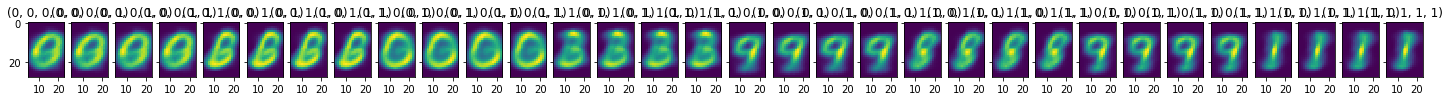

In [21]:
from itertools import product
f, axes = plt.subplots(1, 2**N, sharey=True, figsize=(25,1))
k = 0
for path in product(range(2), repeat=N):
    w = D.forward(Variable(torch.Tensor(path).type(torch.FloatTensor)))
    ax = axes[k]
    ax.set_title(path)
    ax.imshow(w.view(28,28).data.numpy())
    k += 1